rs7130173 is on chrom 11:111154072 A>C, we use the cross validation fold with chrom 11 in test set (split 7)

In [24]:
snp='rs7130173'
fold=7
snp_chrom="chr11"
snp_pos=111154072

In [25]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [26]:
from keras.models import load_model

In [27]:
import pysam
# SNP is at position 101 in the 200 bp MPRA construct 
def get_inputs(chrom,snp_pos,flank=100,ref="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(len(left_flank))
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(len(right_flank))
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

In [28]:
from abstention.calibration import PlattScaling, IsotonicRegression
from scipy.special import logit 

In [33]:
##load the model 
import pickle
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from kerasAC.custom_losses import get_ambig_binary_crossentropy
import numpy as np 
custom_objects={"sensitivity":tpr,
                "specificity":tnr,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":get_ambig_binary_crossentropy()}

model=load_model("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),custom_objects=custom_objects)
predictions=pickle.load(open("/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/predictions."+str(fold),'rb'))
test_set_prediction_logits=predictions[-2]
test_set_labels=predictions[1]
#don't calibrate on nan inputs
try:
    test_set_labels=test_set_labels.values
except:
    pass
  
calibration_functions=dict() 
for i in range(5):
    nonambiguous_indices=np.argwhere(~np.isnan(test_set_labels[:,i]))
    classification_calibration_func = PlattScaling()(
    valid_preacts=test_set_prediction_logits[nonambiguous_indices,i],
    valid_labels=test_set_labels[nonambiguous_indices,i])
    calibration_functions[i]=classification_calibration_func

Platt scaling coef: 1.24405620036609 ; intercept: -0.8595079915768112
Platt scaling coef: 1.217885877096034 ; intercept: -1.6965075093038577
Platt scaling coef: 1.200502837391049 ; intercept: -1.1336722142942355
Platt scaling coef: 1.2255820925495289 ; intercept: -0.8900258060635629
Platt scaling coef: 1.4279198043337074 ; intercept: -0.410730061108719


In [34]:
#get deepLIFT function
from dragonn.tutorial_utils import * 
from dragonn.utils import one_hot_encode

 We have the fasta sequence from "CC_pilot-MPRA.fa"

>rs7130173-bash
CACCATGTTGGCCAGGATGGTCTCAATCTCTTGACCTCGTGATCCGCCAGCCTGGGCCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCACCGAGCCTGCaCCACCAAGGGAAACTTTATGTAGCCGGCACTGTCTTCCTAAACGTGCTGGGCCCTGGTGAGTTGAGTGAAGGAgTCCaTGAGGCCACAAGAGGGCAGCA


In [35]:
mpra_seq="CACCATGTTGGCCAGGATGGTCTCAATCTCTTGACCTCGTGATCCGCCAGCCTGGGCCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCACCGAGCCTGCaCCACCAAGGGAAACTTTATGTAGCCGGCACTGTCTTCCTAAACGTGCTGGGCCCTGGTGAGTTGAGTGAAGGAgTCCaTGAGGCCACAAGAGGGCAGCA"

In [36]:
mpra_seq[100] #reference allele "a" at position 101 in the sequence , 100 bp left flank, 99 bp right flank 

'a'

In [37]:
## extract the 1kb region centered at the SNP 
X,seqs=get_inputs(snp_chrom,snp_pos)


100
99


In [38]:
X['A'].shape

(1, 1, 200, 4)

In [39]:
seqs['A']

'caccatgttggccaggatggtctcaatctcttgacctcgtgatccgccagcctgggcctcccaaagtgctgggattacaggtgtgagccaccgagcctgCACCACCAAGGGAAACTTTATGTAGCCGGCACTGTCTTCCTAAACGTGCTGGGCCCTGGTGAGTTGAGTGAAGGAGTCCATGAGGCCACAAGAGGGCAGCA'

In [40]:
#verify we have extracted the same sequence that was used in the MPRA 
seqs['A'].upper()==mpra_seq.upper()

True

In [41]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs(snp_chrom,snp_pos,flank=500)
X['A'].shape

500
499


(1, 1, 1000, 4)

In [48]:
tasks=["Healthy",'Tumor',"SW480","HCT116","COLO205"]
## pretty print
print('\t'+'\t'.join(tasks))
# get the model predictions 
for base in ['A','C','G','T']: 
    cur_prediction=model.predict(X[base])
    calibrated_predictions=[] 
    for i in range(len(tasks)): 
        calibrated_predictions.append(calibration_functions[i](logit(cur_prediction)[0,i])[0])
    print(base+'\t'+'\t'.join([str(round(i,3)) for i in calibrated_predictions]))

	Healthy	Tumor	SW480	HCT116	COLO205
A	0.515	0.842	0.937	0.943	0.046
C	0.534	0.846	0.934	0.943	0.046
G	0.519	0.827	0.927	0.939	0.051
T	0.494	0.824	0.937	0.943	0.042


In [51]:
## Healthy	Tumor	SW480	HCT116	COLO205 (task order)
dl_scores=dict() 
for t_index in range(5):
    dl_scores[tasks[t_index]]=dict() 
    for base in ['A','C','G','T']:
        dl_scores[tasks[t_index]][base]=deeplift("v4/gecco.classification.SummitWithin200bpCenter."+str(fold),
                                         X[base],
                                         task_idx=t_index,
                                         batch_size=1)

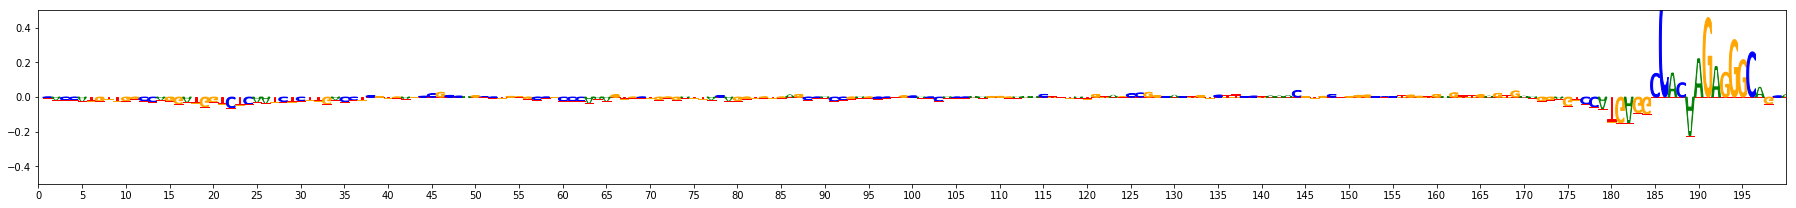

In [52]:
tmp1=dl_scores['HCT116']['A'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]
plot_seq_importance(tmp1,tmp2,ylim=(-0.5,0.5))

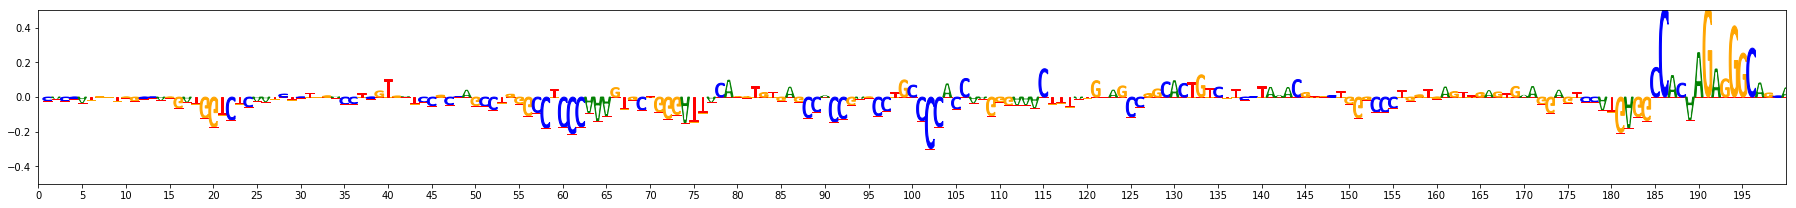

In [39]:
tmp3=dl_scores['HCT116']['C'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=(-0.5,0.5))

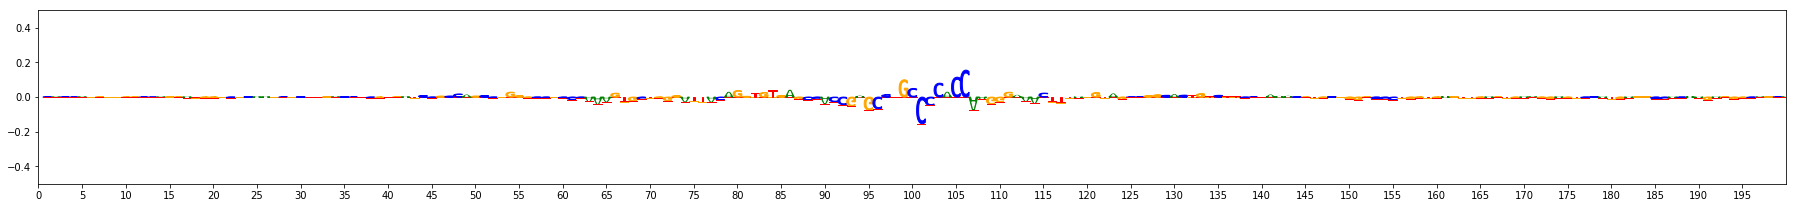

In [41]:
#delta track for the alternate C allele - reference A allele (with C at position 101)
plot_seq_importance(tmp3-tmp1,tmp4,ylim=(-0.5,0.5))

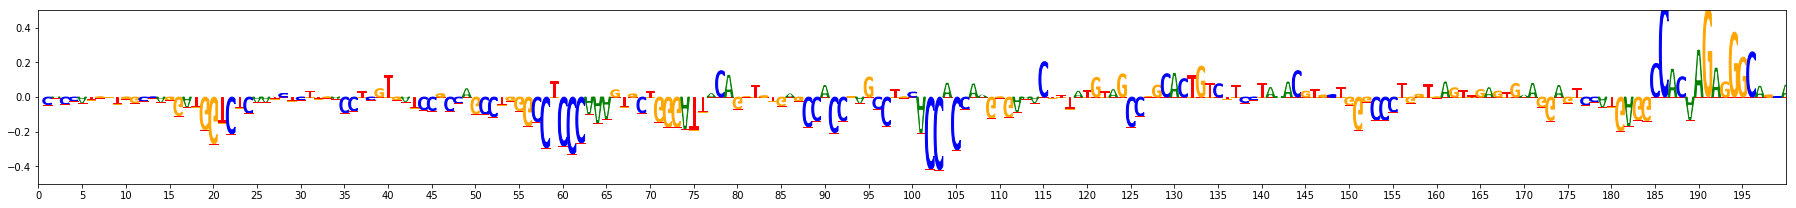

In [42]:
tmp1=dl_scores['SW480']['A'][0].squeeze()[400:600]
tmp2=X['A'].squeeze()[400:600]

plot_seq_importance(tmp1,tmp2,ylim=(-0.5,0.5))

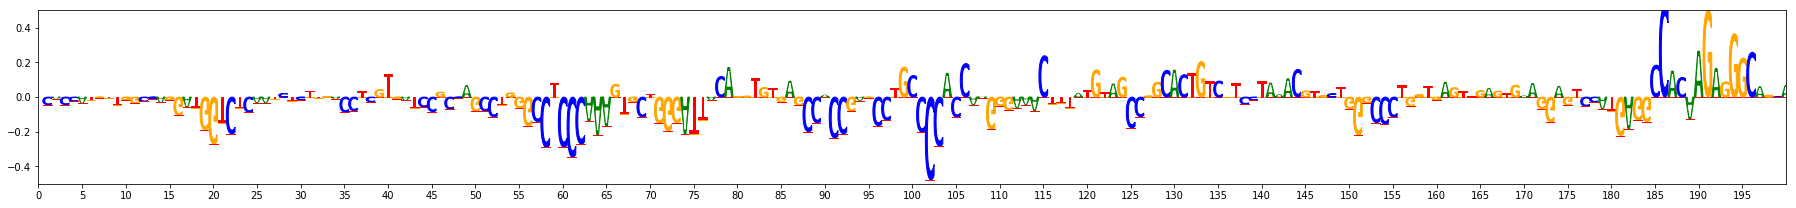

In [43]:
tmp3=dl_scores['SW480']['C'][0].squeeze()[400:600]
tmp4=X['C'].squeeze()[400:600]
plot_seq_importance(tmp3,tmp4,ylim=(-0.5,0.5))

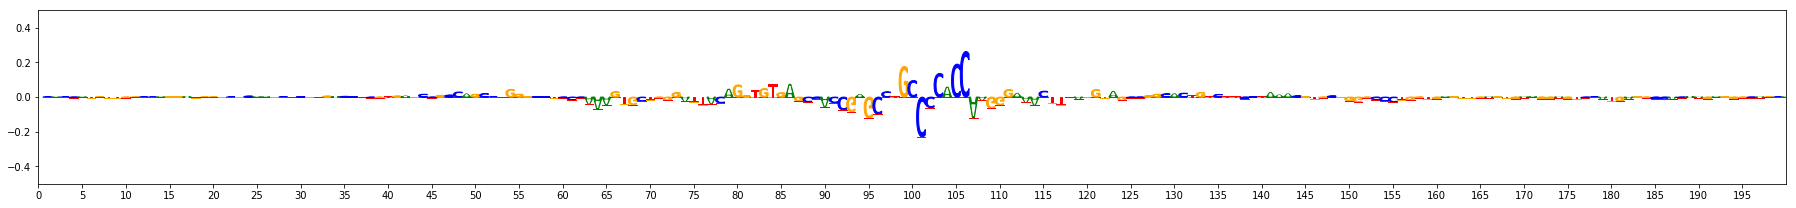

In [44]:
plot_seq_importance(tmp3-tmp1,tmp4,ylim=(-0.5,0.5))

In [36]:
import pandas as pd 
bashed=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_HCT116_20180208.out",header=0,sep='\t')

In [37]:
bashed

,Row.names,SNP,Project,window,strand,allele,haplotype,bash,Ctrl.Mean,Exp.Mean,log2FoldChange,lfcSE,stat,pvalue,padj
0,(rs6507874:rs6507875:CC-bash_M:g93A;rs6507874:...,rs6507874:rs6507875:CC-bash,bash,NaN,rev,NaN,ref,M:g93A,1106.282775,1041.784418,-0.086092,0.134206,-0.641489,5.212050e-01,7.679299e-01
1,(rs6507874:rs6507875:CC-bash_M:g93T;rs6507874:...,rs6507874:rs6507875:CC-bash,bash,NaN,rev,NaN,ref,M:g93T,927.357086,906.494547,-0.032622,0.138925,-0.234816,8.143516e-01,9.265243e-01
2,(rs6507874:rs6507875:CC-bash;rs6507874:rs65078...,rs6507874:rs6507875:CC-bash,bash,NaN,rev,NaN,ref,ref,10685.015473,10460.241526,-0.030670,0.057713,-0.531427,5.951230e-01,8.162193e-01
3,(rs6507874:rs6507875:CG-bash_M:g107T;rs6507874...,rs6507874:rs6507875:CG-bash,bash,NaN,rev,NaN,ref,M:g107T,1420.272306,1474.466440,0.054679,0.091932,0.594779,5.519912e-01,7.896405e-01
4,(rs6507874:rs6507875:CG-bash;rs6507874:rs65078...,rs6507874:rs6507875:CG-bash,bash,NaN,rev,NaN,ref,ref,6500.313252,6367.043572,-0.029839,0.095733,-0.311688,7.552774e-01,9.010281e-01
5,(rs6507874:rs6507875:TC-bash_M:a107C;rs6507874...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,M:a107C,1939.838257,1825.183773,-0.088352,0.126818,-0.696685,4.860002e-01,7.437987e-01
6,(rs6507874:rs6507875:TC-bash_M:a107T;rs6507874...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,M:a107T,2338.063022,2536.685920,0.117590,0.123022,0.955846,3.391500e-01,6.227182e-01
7,(rs6507874:rs6507875:TC-bash_M:g93T;rs6507874:...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,M:g93T,2137.806400,2508.904606,0.230528,0.104347,2.209241,2.715786e-02,1.155894e-01
8,(rs6507874:rs6507875:TC-bash;rs6507874:rs65078...,rs6507874:rs6507875:TC-bash,bash,NaN,rev,NaN,ref,ref,7171.257311,6757.766057,-0.085713,0.077250,-1.109547,2.671941e-01,5.481396e-01
9,(rs6507874:rs6507875:TG-bash_M:a107C;rs6507874...,rs6507874:rs6507875:TG-bash,bash,NaN,rev,NaN,ref,M:a107C,971.008535,1106.639371,0.188119,0.152052,1.237197,2.160138e-01,4.866579e-01


In [53]:

bashed_snp_subset=dict()
bashed_snp_subset['pos']=[]
bashed_snp_subset['allele']=[]
bashed_snp_subset['lfc']=[]
for index,row in bashed.iterrows(): 
    if str(row['SNP']).startswith(snp) and row['SNP'].endswith('bash'): 
        #this is our target SNP
        bashinfo=row['bash']
        if bashinfo=='ref':
            continue
        bashinfo=bashinfo.split(":")[1]
        ref_allele=bashinfo[0].upper() 
        alt_allele=bashinfo[-1]
        pos=int(bashinfo[1:-1])
        bashed_snp_subset['pos'].append(pos)
        bashed_snp_subset['allele'].append(alt_allele)
        bashed_snp_subset['lfc'].append(row['log2FoldChange'])
        

In [55]:
bashed_snp_subset=pd.DataFrame(bashed_snp_subset)

In [ ]:
bashed_snp_subset

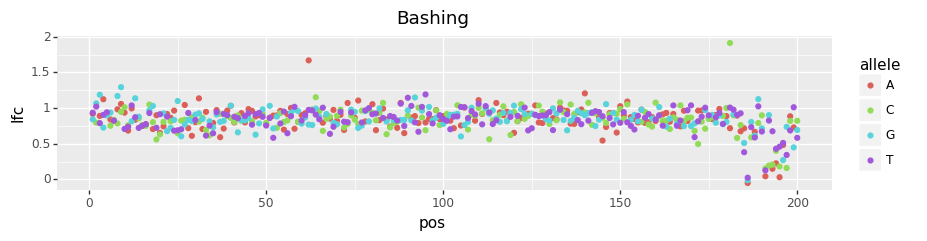

<ggplot: (-9223363253727202076)>

In [84]:
from plotnine import * 
plotnine.options.figure_size = (10,2)

(ggplot(bashed_snp_subset)
 +aes(x="pos",y="lfc",group="allele",color="allele")
 +geom_point()
 +ggtitle("Bashing"))

In [85]:
dl_ref=np.asarray(dl_scores['HCT116']['A'][0].squeeze()[400:600])
dl_ref=pd.DataFrame(dl_ref,columns=["A","C","G","T"])
dl_ref['pos']=range(1,201)
dl_ref_melted=pd.melt(dl_ref, id_vars=['pos'])
dl_ref_melted.columns=['pos','allele','deepLIFT']

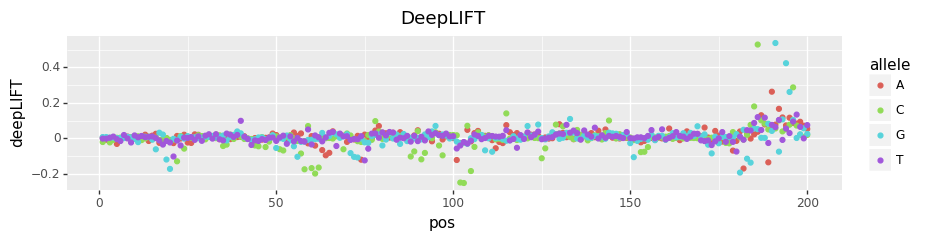

<ggplot: (8783127919389)>

In [86]:
plotnine.options.figure_size = (10,2)

(ggplot(dl_ref_melted)
 +aes(x="pos",y="deepLIFT",group="allele",color="allele")
 +geom_point()
 +ggtitle("DeepLIFT"))

## SW480

In [88]:
import pandas as pd 
bashed=pd.read_csv("/srv/scratch/annashch/gecco/20190207_Pilot_Data_Freeze_1/CC_Pilot_SW480_20180208.out",header=0,sep='\t')

In [89]:

bashed_snp_subset=dict()
bashed_snp_subset['pos']=[]
bashed_snp_subset['allele']=[]
bashed_snp_subset['lfc']=[]
for index,row in bashed.iterrows(): 
    if str(row['SNP']).startswith(snp) and row['SNP'].endswith('bash'): 
        #this is our target SNP
        bashinfo=row['bash']
        if bashinfo=='ref':
            continue
        bashinfo=bashinfo.split(":")[1]
        ref_allele=bashinfo[0].upper() 
        alt_allele=bashinfo[-1]
        pos=int(bashinfo[1:-1])
        bashed_snp_subset['pos'].append(pos)
        bashed_snp_subset['allele'].append(alt_allele)
        bashed_snp_subset['lfc'].append(row['log2FoldChange'])
        

In [90]:
bashed_snp_subset=pd.DataFrame(bashed_snp_subset)

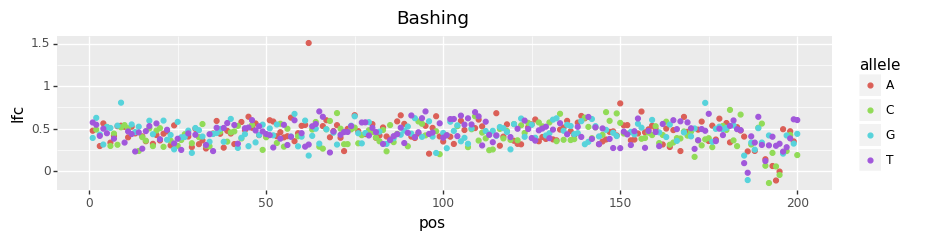

<ggplot: (-9223363253726971427)>

In [91]:
from plotnine import * 
plotnine.options.figure_size = (10,2)

(ggplot(bashed_snp_subset)
 +aes(x="pos",y="lfc",group="allele",color="allele")
 +geom_point()
 +ggtitle("Bashing"))

In [94]:
dl_ref=np.asarray(dl_scores['SW480']['A'][0].squeeze()[400:600])
dl_ref=pd.DataFrame(dl_ref,columns=["A","C","G","T"])
dl_ref['pos']=range(1,201)
dl_ref_melted=pd.melt(dl_ref, id_vars=['pos'])
dl_ref_melted.columns=['pos','allele','deepLIFT']

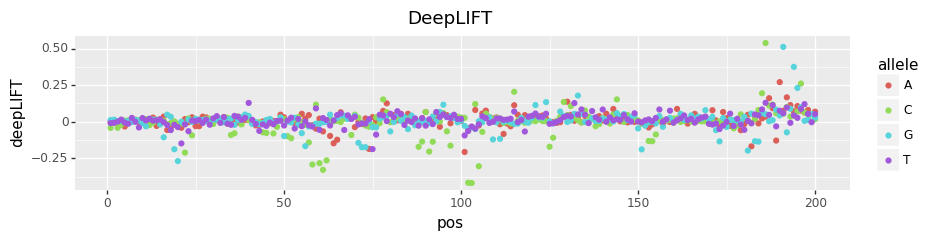

<ggplot: (-9223363253727208276)>

In [95]:
plotnine.options.figure_size = (10,2)

(ggplot(dl_ref_melted)
 +aes(x="pos",y="deepLIFT",group="allele",color="allele")
 +geom_point()
 +ggtitle("DeepLIFT"))